<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Time Series Forecasting**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
time: 2.95 ms (started: 2021-05-13 14:00:18 +00:00)


#### **Load Data**

**Sunspot Dataset**

In [2]:
# https://www.kaggle.com/robervalt/sunspots
# https://www.kaggle.com/leeminwoo/keras-bidirectonal-lstm
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sunspots.csv.xls'
data = pd.read_csv(url)
data = data[['Date', 'Monthly Mean Total Sunspot Number']].rename(columns={"Date": "date", "Monthly Mean Total Sunspot Number": "sunspots"}).set_index('date')
data.index = pd.to_datetime(data.index, utc=False)
dataset = data.copy()
dataset.head()

,sunspots
date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


time: 93.7 ms (started: 2021-05-13 14:00:18 +00:00)


**Google Stock Data**

In [3]:
# url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
# data = pd.read_csv(url)
# series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
# series.index = pd.to_datetime(series.index, utc=False)
# series.head()
# dataset = series.copy()
# dataset.head()

time: 1.85 ms (started: 2021-05-13 14:00:18 +00:00)


**Insolvenzverfahren**

In [4]:
# url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sh_unmelt_bq_raw.csv'
# sh_unmelt_bq_raw = pd.read_csv(url)
# sh_unmelt_bq_raw = sh_unmelt_bq_raw.sort_values('datum')
# dataset = sh_unmelt_bq_raw.copy()
# dataset = dataset.drop(columns=['Bergbau', 'Dienstleistungen', 'Energieversorgung','Erziehung', 'Finanzleistungen', 'Gastgewerbe','IT', 'Manufaktur', 'Sonstiges','Sozialwesen', 'Verkehr', 'Wohnungswesen'])
# dataset = dataset.set_index('datum')
# dataset.index = pd.to_datetime(dataset.index, utc=False)
# dataset.head()

time: 2.13 ms (started: 2021-05-13 14:00:18 +00:00)


#### **Set input data**

In [5]:
# Set data
data = dataset.copy()

# Set seed for reproducibility
tf.random.set_seed(7)

time: 2.72 ms (started: 2021-05-13 14:00:18 +00:00)


#### **Normalize input data**

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

time: 4.42 ms (started: 2021-05-13 14:00:18 +00:00)


In [7]:
print(dataset.shape)
# print(dataset.dtype)

(3265, 1)
time: 2.38 ms (started: 2021-05-13 14:00:18 +00:00)


In [8]:
# Display dataset
data [0:10] # Display first 10 values

array([[0.24284279],
       [0.26192868],
       [0.29306881],
       [0.23304872],
       [0.35585133],
       [0.34957308],
       [0.39678553],
       [0.27749874],
       [0.31767956],
       [0.31592165]])

time: 4.89 ms (started: 2021-05-13 14:00:18 +00:00)


#### **Train & Test Split**

In [9]:
# Train & Test Split in % of complete dataset
split = 0.9
train_size = int(len(data) * split)
test_size = len(dataset) - train_size
train, test = data[0:train_size,:], data[train_size:len(dataset),:]

time: 3.38 ms (started: 2021-05-13 14:00:18 +00:00)


In [10]:
train [0:10] # Display first 10 values

array([[0.24284279],
       [0.26192868],
       [0.29306881],
       [0.23304872],
       [0.35585133],
       [0.34957308],
       [0.39678553],
       [0.27749874],
       [0.31767956],
       [0.31592165]])

time: 5.21 ms (started: 2021-05-13 14:00:18 +00:00)


In [11]:
test [0:10] # Display first 10 values

array([[0.1210447 ],
       [0.17177298],
       [0.21320944],
       [0.13787042],
       [0.11928679],
       [0.06880964],
       [0.07483677],
       [0.09969864],
       [0.12707182],
       [0.08613762]])

time: 5.06 ms (started: 2021-05-13 14:00:18 +00:00)


Now train & test data have been separated. 

We need to divide by feature input (X) and prediction variable (Y).

For both train and test dataset

#### **Window & Reshape**

In [12]:
window = 30 # Use (t), (t-1) and (t-2) as input variables X
features = 1 # we have only one time series

time: 1.78 ms (started: 2021-05-13 14:00:19 +00:00)


In [13]:
# Convert an array of values into a dataset matrix
def create_dataset(data, window=window):
    dataX, dataY = [], []
    for i in range(len(data)-window-1):
        a = data[i:(i+window), 0]
        dataX.append(a)
        dataY.append(data[i + window, 0])
    return np.array(dataX), np.array(dataY)

# X is input data = value (at t, and t-1, t-2, depending on window size)
# Y is target data = value at t+1
# Each is additionally divided into train and test set

time: 8.22 ms (started: 2021-05-13 14:00:19 +00:00)


In [14]:
# Reshape into X=t and Y=t+1 and get as arrays
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

time: 10.5 ms (started: 2021-05-13 14:00:19 +00:00)


In [15]:
print(trainX.shape)

(2907, 30)
time: 2.9 ms (started: 2021-05-13 14:00:19 +00:00)


In [16]:
print(trainY.shape)

(2907,)
time: 6.29 ms (started: 2021-05-13 14:00:19 +00:00)


In [17]:
# X input has 3 (= window size) values at each step
trainX [0:10] # Display first 10 values

array([[0.24284279, 0.26192868, 0.29306881, 0.23304872, 0.35585133,
        0.34957308, 0.39678553, 0.27749874, 0.31767956, 0.31592165,
        0.66373682, 0.35660472, 0.30688096, 0.31767956, 0.37343044,
        0.36966349, 0.37669513, 0.41863385, 0.35735811, 0.43119036,
        0.38171773, 0.27498744, 0.26494224, 0.31567052, 0.29306881,
        0.18206931, 0.18960321, 0.23606228, 0.25414365, 0.21220492],
       [0.26192868, 0.29306881, 0.23304872, 0.35585133, 0.34957308,
        0.39678553, 0.27749874, 0.31767956, 0.31592165, 0.66373682,
        0.35660472, 0.30688096, 0.31767956, 0.37343044, 0.36966349,
        0.37669513, 0.41863385, 0.35735811, 0.43119036, 0.38171773,
        0.27498744, 0.26494224, 0.31567052, 0.29306881, 0.18206931,
        0.18960321, 0.23606228, 0.25414365, 0.21220492, 0.27749874],
       [0.29306881, 0.23304872, 0.35585133, 0.34957308, 0.39678553,
        0.27749874, 0.31767956, 0.31592165, 0.66373682, 0.35660472,
        0.30688096, 0.31767956, 0.37343044, 0.

time: 11.5 ms (started: 2021-05-13 14:00:19 +00:00)


In [18]:
# Y output has here only one value (t+1) at each step
trainY

array([0.27749874, 0.2503767 , 0.09844299, ..., 0.20190859, 0.1569563 ,
       0.07835259])

time: 5.18 ms (started: 2021-05-13 14:00:19 +00:00)


In [19]:
trainX.shape[0]

2907

time: 5.15 ms (started: 2021-05-13 14:00:19 +00:00)


In [20]:
trainX.shape[1]

30

time: 4.33 ms (started: 2021-05-13 14:00:19 +00:00)


#### **Reshape Data Format for LSTM**

In [21]:
# Reshape Data Format for LSTM (simple model)

# Data is in shape **[samples, features]**. LSTM expects **[samples, time steps, features]**
# Reminder 2D array: shape (n,m), n [0] = rows (time steps), m [1] = column(s)
# Shape: First Block: t, t+1, t+2. Second: t+1, t+2, t+3. Third: t+2, t+3, t+4.
# Approach 1: Use past observations as separate input features =(trainX.shape[0], features, trainX.shape[1])

# trainX = np.reshape(trainX, (trainX.shape[0], features, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], features, testX.shape[1]))

time: 2.81 ms (started: 2021-05-13 14:00:19 +00:00)


In [22]:
# Approach 2: Use past observations as time steps of the one input feature

trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], features))
trainX

<tf.Tensor: shape=(2907, 30, 1), dtype=float64, numpy=
array([[[0.24284279],
        [0.26192868],
        [0.29306881],
        ...,
        [0.23606228],
        [0.25414365],
        [0.21220492]],

       [[0.26192868],
        [0.29306881],
        [0.23304872],
        ...,
        [0.25414365],
        [0.21220492],
        [0.27749874]],

       [[0.29306881],
        [0.23304872],
        [0.35585133],
        ...,
        [0.21220492],
        [0.27749874],
        [0.2503767 ]],

       ...,

       [[0.49045706],
        [0.6034656 ],
        [0.49472627],
        ...,
        [0.2370668 ],
        [0.19789051],
        [0.17478654]],

       [[0.6034656 ],
        [0.49472627],
        [0.49623305],
        ...,
        [0.19789051],
        [0.17478654],
        [0.20190859]],

       [[0.49472627],
        [0.49623305],
        [0.41913611],
        ...,
        [0.17478654],
        [0.20190859],
        [0.1569563 ]]])>

time: 41.2 ms (started: 2021-05-13 14:00:19 +00:00)


In [23]:
print(trainX.shape)

(2907, 30, 1)
time: 2.53 ms (started: 2021-05-13 14:00:19 +00:00)


In [24]:
trainX [0:10] # Display first 10 values

<tf.Tensor: shape=(10, 30, 1), dtype=float64, numpy=
array([[[0.24284279],
        [0.26192868],
        [0.29306881],
        [0.23304872],
        [0.35585133],
        [0.34957308],
        [0.39678553],
        [0.27749874],
        [0.31767956],
        [0.31592165],
        [0.66373682],
        [0.35660472],
        [0.30688096],
        [0.31767956],
        [0.37343044],
        [0.36966349],
        [0.37669513],
        [0.41863385],
        [0.35735811],
        [0.43119036],
        [0.38171773],
        [0.27498744],
        [0.26494224],
        [0.31567052],
        [0.29306881],
        [0.18206931],
        [0.18960321],
        [0.23606228],
        [0.25414365],
        [0.21220492]],

       [[0.26192868],
        [0.29306881],
        [0.23304872],
        [0.35585133],
        [0.34957308],
        [0.39678553],
        [0.27749874],
        [0.31767956],
        [0.31592165],
        [0.66373682],
        [0.35660472],
        [0.30688096],
        [0.31767956],

time: 15.3 ms (started: 2021-05-13 14:00:19 +00:00)


In [25]:
print(testX.shape)

(296, 30, 1)
time: 2.58 ms (started: 2021-05-13 14:00:19 +00:00)


#### **Model Training**

In [26]:
# Set Hyperparameter
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.LogCosh() # or 'huber' or 'mean_squared_error'
activation = 'relu'
dropout = 0.02
epochs = 15
verbose = 1
units = 1 # LSTM output units
repeat = 1
batch_size = 1

time: 7.23 ms (started: 2021-05-13 14:00:19 +00:00)


In [27]:
model = keras.Sequential(name="my_sequential")

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

# Add a LSTM layer with internal units.
model.add(layers.LSTM(units, 
                      input_shape=(window, features),
                      dropout = dropout,
                      return_sequences=False, 
                      activation=activation, 
                      name="layer1"))

# Add a Dense layer with 1 unit (das aktivieren, falls LSTM output units > 1)
# model.add(layers.Dense(1, activation = 'linear', name="layer2"))

# Call model on a test input
trainY = model(trainX)

time: 269 ms (started: 2021-05-13 14:00:19 +00:00)


In [28]:
model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
time: 6.81 ms (started: 2021-05-13 14:00:19 +00:00)


In [29]:
trainY.shape

TensorShape([2907, 1])

time: 3.21 ms (started: 2021-05-13 14:00:19 +00:00)


In [30]:
# model.weights

time: 1.08 ms (started: 2021-05-13 14:00:19 +00:00)


In [31]:
# print("Number of weights after calling the model:", len(model.weights))

time: 929 µs (started: 2021-05-13 14:00:19 +00:00)


In [32]:
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['mse'])

time: 23.4 ms (started: 2021-05-13 14:00:19 +00:00)


In [33]:
# Prepare visualisation - Plot Losses Keras TF (simple)
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF

# Select visualization method
callbacks = [PlotLossesKerasTF()]

time: 2.96 s (started: 2021-05-13 14:00:19 +00:00)


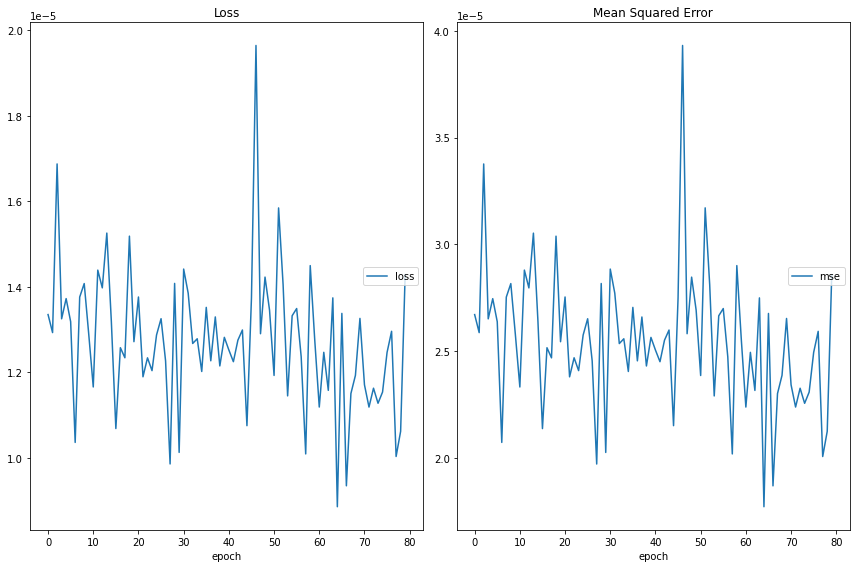

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
Mean Squared Error
	mse              	 (min:    0.000, max:    0.000, cur:    0.000)


time: 1min 49s (started: 2021-05-13 14:00:22 +00:00)


In [34]:
# Train model
model.fit(trainX,
          trainY, 
          epochs=epochs, 
          verbose=verbose, 
          shuffle=False, 
          callbacks=callbacks)

#### **Make Predictions**

In [35]:
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

time: 471 ms (started: 2021-05-13 14:02:12 +00:00)


#### **Predictions (Train & Test)**

**Test Predict**

In [36]:
testPredict [0:10]

array([[0.02011217],
       [0.01797174],
       [0.02088983],
       [0.0207491 ],
       [0.02442836],
       [0.01902099],
       [0.01420214],
       [0.02240003],
       [0.02304174],
       [0.02006119]], dtype=float32)

time: 8.33 ms (started: 2021-05-13 14:02:12 +00:00)


In [37]:
testPredict = scaler.inverse_transform(testPredict)
testPredict [0:10]

array([[8.008667 ],
       [7.1563473],
       [8.318329 ],
       [8.26229  ],
       [9.727373 ],
       [7.5741568],
       [5.6552916],
       [8.919692 ],
       [9.1752205],
       [7.988367 ]], dtype=float32)

time: 6.12 ms (started: 2021-05-13 14:02:12 +00:00)


**Train Predict**

In [38]:
trainPredict [0:10]

array([[0.13136576],
       [0.1348214 ],
       [0.1373658 ],
       [0.12100115],
       [0.10170856],
       [0.09192733],
       [0.09544891],
       [0.09462059],
       [0.10144081],
       [0.11920251]], dtype=float32)

time: 7.19 ms (started: 2021-05-13 14:02:12 +00:00)


In [39]:
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict [0:10]

array([[52.309845],
       [53.685883],
       [54.699062],
       [48.182655],
       [40.50035 ],
       [36.60546 ],
       [38.007755],
       [37.677917],
       [40.39373 ],
       [47.46644 ]], dtype=float32)

time: 11.6 ms (started: 2021-05-13 14:02:12 +00:00)


#### **Actual (Train & Test)**

**Test Actual**

In [40]:
testY [0:10]

array([0.01908589, 0.04143646, 0.02963335, 0.04947263, 0.0075339 ,
       0.00175791, 0.06253139, 0.03515821, 0.01858363, 0.02762431])

time: 8.24 ms (started: 2021-05-13 14:02:12 +00:00)


In [41]:
testY = scaler.inverse_transform([testY])
testY [0:10]

array([[7.600e+00, 1.650e+01, 1.180e+01, 1.970e+01, 3.000e+00, 7.000e-01,
        2.490e+01, 1.400e+01, 7.400e+00, 1.100e+01, 1.210e+01, 2.300e+01,
        2.540e+01, 2.080e+01, 1.290e+01, 3.570e+01, 5.970e+01, 3.280e+01,
        5.040e+01, 5.550e+01, 4.450e+01, 5.020e+01, 8.200e+01, 7.060e+01,
        7.400e+01, 9.050e+01, 9.670e+01, 1.211e+02, 1.320e+02, 7.850e+01,
        9.730e+01, 1.192e+02, 8.600e+01, 9.800e+01, 1.035e+02, 9.360e+01,
        1.496e+02, 2.072e+02, 1.735e+02, 1.423e+02, 1.063e+02, 1.687e+02,
        1.883e+02, 1.168e+02, 1.331e+02, 1.657e+02, 2.177e+02, 1.915e+02,
        1.659e+02, 1.880e+02, 2.443e+02, 1.805e+02, 1.560e+02, 1.416e+02,
        1.581e+02, 1.433e+02, 1.426e+02, 1.215e+02, 1.658e+02, 1.617e+02,
        1.421e+02, 2.029e+02, 1.230e+02, 1.615e+02, 2.382e+02, 1.941e+02,
        1.766e+02, 2.134e+02, 1.846e+02, 1.702e+02, 1.471e+02, 1.869e+02,
        1.875e+02, 1.288e+02, 1.610e+02, 1.756e+02, 1.879e+02, 1.512e+02,
        1.472e+02, 1.353e+02, 1.335e+0

time: 13.7 ms (started: 2021-05-13 14:02:12 +00:00)


**Train Actual**

In [42]:
trainY [0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.13177486],
       [0.13528933],
       [0.13781205],
       [0.12129004],
       [0.10203832],
       [0.09229296],
       [0.09582809],
       [0.09500281],
       [0.10183208],
       [0.11957234]], dtype=float32)>

time: 7.26 ms (started: 2021-05-13 14:02:12 +00:00)


In [43]:
# Convert / Create a numpy ndarray from a tensor
trainY = tf.make_tensor_proto(trainY)  # convert `tensor a` to a proto tensor
trainY = tf.make_ndarray(trainY)
trainY [0:10]

array([[0.13177486],
       [0.13528933],
       [0.13781205],
       [0.12129004],
       [0.10203832],
       [0.09229296],
       [0.09582809],
       [0.09500281],
       [0.10183208],
       [0.11957234]], dtype=float32)

time: 12 ms (started: 2021-05-13 14:02:13 +00:00)


In [44]:
trainY.shape

(2907, 1)

time: 6.21 ms (started: 2021-05-13 14:02:13 +00:00)


In [45]:
# trainY = scaler.inverse_transform([trainY])
trainY [0:10]

array([[0.13177486],
       [0.13528933],
       [0.13781205],
       [0.12129004],
       [0.10203832],
       [0.09229296],
       [0.09582809],
       [0.09500281],
       [0.10183208],
       [0.11957234]], dtype=float32)

time: 6.89 ms (started: 2021-05-13 14:02:13 +00:00)


#### **Residuals**

In [46]:
# Get residuals
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,-0.408667
1,9.343653
2,3.481671
3,11.437710
4,-6.727373


time: 19.1 ms (started: 2021-05-13 14:02:13 +00:00)


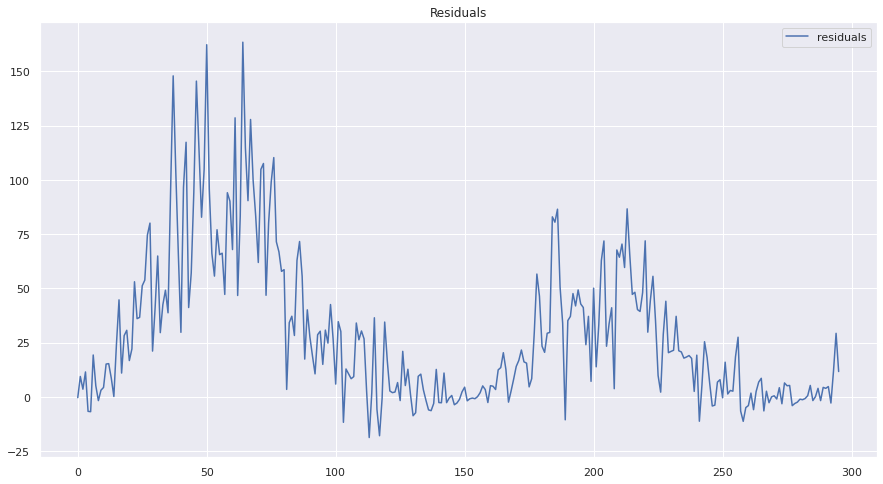

time: 463 ms (started: 2021-05-13 14:02:13 +00:00)


In [47]:
# Plot Residuals
sns.set(rc={'figure.figsize':(15, 8)})
res.plot(title='Residuals')

#### **Calculate RMSE & Plot**

In [48]:
# Inverse original data
data = scaler.inverse_transform(data)
data

array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [ 34. ],
       [ 21.8],
       [ 10.4]])

time: 4.49 ms (started: 2021-05-13 14:02:13 +00:00)


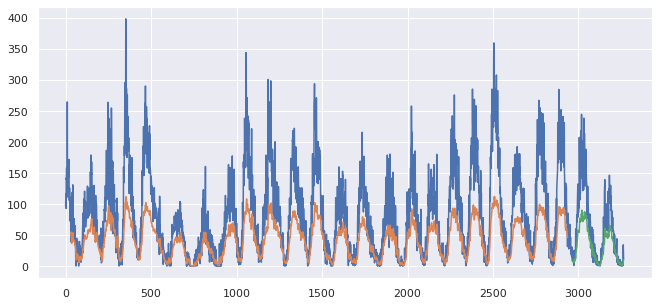

time: 377 ms (started: 2021-05-13 14:02:13 +00:00)


In [49]:
# Plot results

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 45.25 RMSE
time: 3.23 ms (started: 2021-05-13 14:02:13 +00:00)


In [51]:
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

time: 1.11 ms (started: 2021-05-13 14:02:13 +00:00)
